# Segmenting satellite imagery from the Maxar Open Data Program

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/maxar_open_data.ipynb)
[![image](https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft)](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/opengeos/segment-geospatial&urlpath=lab/tree/segment-geospatial/docs/examples/maxar_open_data.ipynb&branch=main)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/maxar_open_data.ipynb)

This notebook shows how to segment satellite imagery from the [Maxar Open Data](https://github.com/opengeos/maxar-open-data) program for Libya floods.  

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [7]:
# %pip install segment-geospatial
# %pip install leafmap
# %pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import os
import leafmap
from samgeo import SamGeo, raster_to_vector, overlay_images

## Download sample data

First, let's download a sample image of Derna, Libya from [here](https://drive.google.com/file/d/1jIIC5hvSPeJEC0fbDhtxVWk2XV9AxsQD/view?usp=sharing).

In [3]:
url = "https://github.com/opengeos/datasets/releases/download/raster/Derna_sample.tif"

In [4]:
leafmap.download_file(url, output="image.tif")

Downloading...
From: https://github.com/opengeos/datasets/releases/download/raster/Derna_sample.tif
To: /content/image.tif
100%|██████████| 12.2M/12.2M [00:00<00:00, 184MB/s]


'/content/image.tif'

In [9]:
#os.getcwd()
import rioxarray as rxr
img_raster=rxr.open_rasterio("/content/image.tif")


print("The crs of your data is:", img_raster.rio.crs)
print("The nodatavalue of your data is:", img_raster.rio.nodata)
print("The shape of your data is:", img_raster.shape)
print("The spatial resolution for your data is:", img_raster.rio.resolution())
print("The metadata for your data is:", img_raster.attrs)

The crs of your data is: EPSG:32634
The nodatavalue of your data is: None
The shape of your data is: (3, 1444, 2804)
The spatial resolution for your data is: (0.3051757879965469, -0.3051757820217067)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}


## Create an interactive map

In [10]:
m = leafmap.Map(height="600px")
m.add_basemap("SATELLITE")
m.add_raster("image.tif", layer_name="Image")
m.add_layer_manager()
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Initialize SAM class

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [11]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 80,
}

In [12]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:46<00:00, 55.0MB/s]


## Segment the image

In [13]:
sam.generate("image.tif", output="mask.tif", foreground=True)

## Convert raster to vector

In [ ]:
raster_to_vector("mask.tif", output="mask.shp")

## Display the segmentation result

First, let's show the result as a binary image.

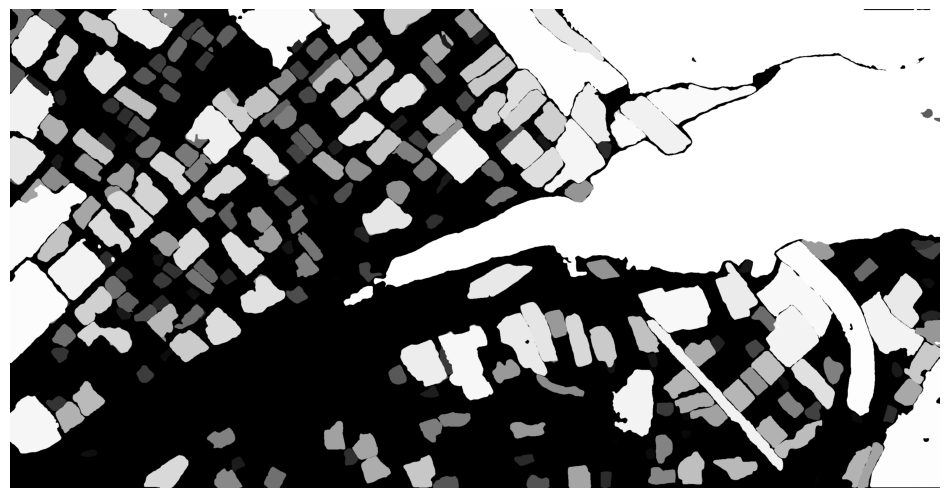

In [14]:
sam.show_masks(cmap="binary_r")

Display the annotations (each mask with a random color).

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotation.tif")

## Compare images with a slider

In [ ]:
leafmap.image_comparison(
    "image.tif",
    "annotation.tif",
    label1="Image",
    label2="Segmentation",
)

Overlay the annotations on the image and use the slider to change the opacity interactively.

In [ ]:
overlay_images("image.tif", "annotation.tif", backend="TkAgg")

## Display images on an interactive map.

In [ ]:
m.add_raster("mask.tif", layer_name="Mask", nodata=0)
m.add_raster("annotation.tif", layer_name="Annotation")
m

In [ ]:
m.add_vector("mask.shp", layer_name="Vector", info_mode=None)

![](https://i.imgur.com/kjMi8AF.png)